<a href="https://colab.research.google.com/github/RealRipper/Bank-Loan-Defaulter-Analysis/blob/main/Loan_Defaulter_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'loan-defaulter:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F807638%2F1383922%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240606%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240606T132205Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5e39fe3a7ad446105f45af0cf20d3aa42bd01a64091ae56e10ba7cd666e622016f42882120ccb0ff813cb1b8dd2702218f50c9bee40afe6f6151e1c444c22e3fbda8bca1d9ee69cb0813ab3f33f4cc789b3e20a71f262ad62cf4c3049ee45e62615b53e19c6ce4e74a76934e1eb07a637b8e6f44f0932f526352d02dead8a511385bb00c8b8baa69653fd4dd5c5b78f418644c5c5a65539a78cc7df89aa49dd32f53eafa8379fbc7836214b225cbc50657ff76cc635e56cdbee167c3b884e0332bd4887b4c6b7e7cebe503e86849809b35759eb54b5b235e44daa6e0f2dc117e8b56191f9c054a0df4fccfb6a654596287627ef0e0dce07c35ab68c802b1503f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117814244 bytes downloaded
Downloaded and uncompressed: loan-defaulter
Data source import complete.


**Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns= None
pd.options.display.max_rows= None

**Importing Data**

In [3]:
app= pd.read_csv("/kaggle/input/loan-defaulter/application_data.csv")
prev_app= pd.read_csv("/kaggle/input/loan-defaulter/previous_application.csv")

In [4]:
app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [5]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


**Feature Selection**

In [6]:
app.shape

(307511, 122)

In [7]:
app.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [8]:
missing_info= pd.DataFrame(app.isnull().sum().sort_values().reset_index())
missing_info.rename(columns={'index':'col_name', 0:'null_count'}, inplace= True)
missing_info.tail()

,col_name,null_count
117,NONLIVINGAPARTMENTS_MEDI,213514
118,NONLIVINGAPARTMENTS_MODE,213514
119,COMMONAREA_MODE,214865
120,COMMONAREA_AVG,214865
121,COMMONAREA_MEDI,214865


In [9]:
missing_info["null_percent"]= (missing_info["null_count"]/app.shape[0])*100
missing_info.tail()

,col_name,null_count,null_percent
117,NONLIVINGAPARTMENTS_MEDI,213514,69.432963
118,NONLIVINGAPARTMENTS_MODE,213514,69.432963
119,COMMONAREA_MODE,214865,69.872297
120,COMMONAREA_AVG,214865,69.872297
121,COMMONAREA_MEDI,214865,69.872297


In [10]:
missing_info.to_excel("missing_info_app.xlsx", index= False)

In [11]:
extra_rows= missing_info[missing_info['null_percent']>=40]
extra_rows_list= extra_rows['col_name'].to_list()
extra_rows_list

['EMERGENCYSTATE_MODE',
 'TOTALAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'HOUSETYPE_MODE',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MODE',
 'LIVINGAREA_MEDI',
 'ENTRANCES_AVG',
 'ENTRANCES_MODE',
 'ENTRANCES_MEDI',
 'APARTMENTS_MEDI',
 'APARTMENTS_AVG',
 'APARTMENTS_MODE',
 'WALLSMATERIAL_MODE',
 'ELEVATORS_MEDI',
 'ELEVATORS_AVG',
 'ELEVATORS_MODE',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'EXT_SOURCE_1',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MEDI',
 'LANDAREA_MEDI',
 'LANDAREA_AVG',
 'LANDAREA_MODE',
 'OWN_CAR_AGE',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'FLOORSMIN_AVG',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'FONDKAPREMONT_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'COMMON

In [12]:
app_updated= app.drop(labels= extra_rows_list, axis= 1)
app_updated.shape

(307511, 73)

In [13]:
flag_col= []

for col in app_updated:
    if col.startswith("FLAG_"):
        flag_col.append(col)

flag_col

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

In [14]:
flag_target= app_updated[flag_col + ["TARGET"]]
flag_target.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,TARGET
0,N,Y,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,N,N,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Y,Y,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,N,Y,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,N,Y,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


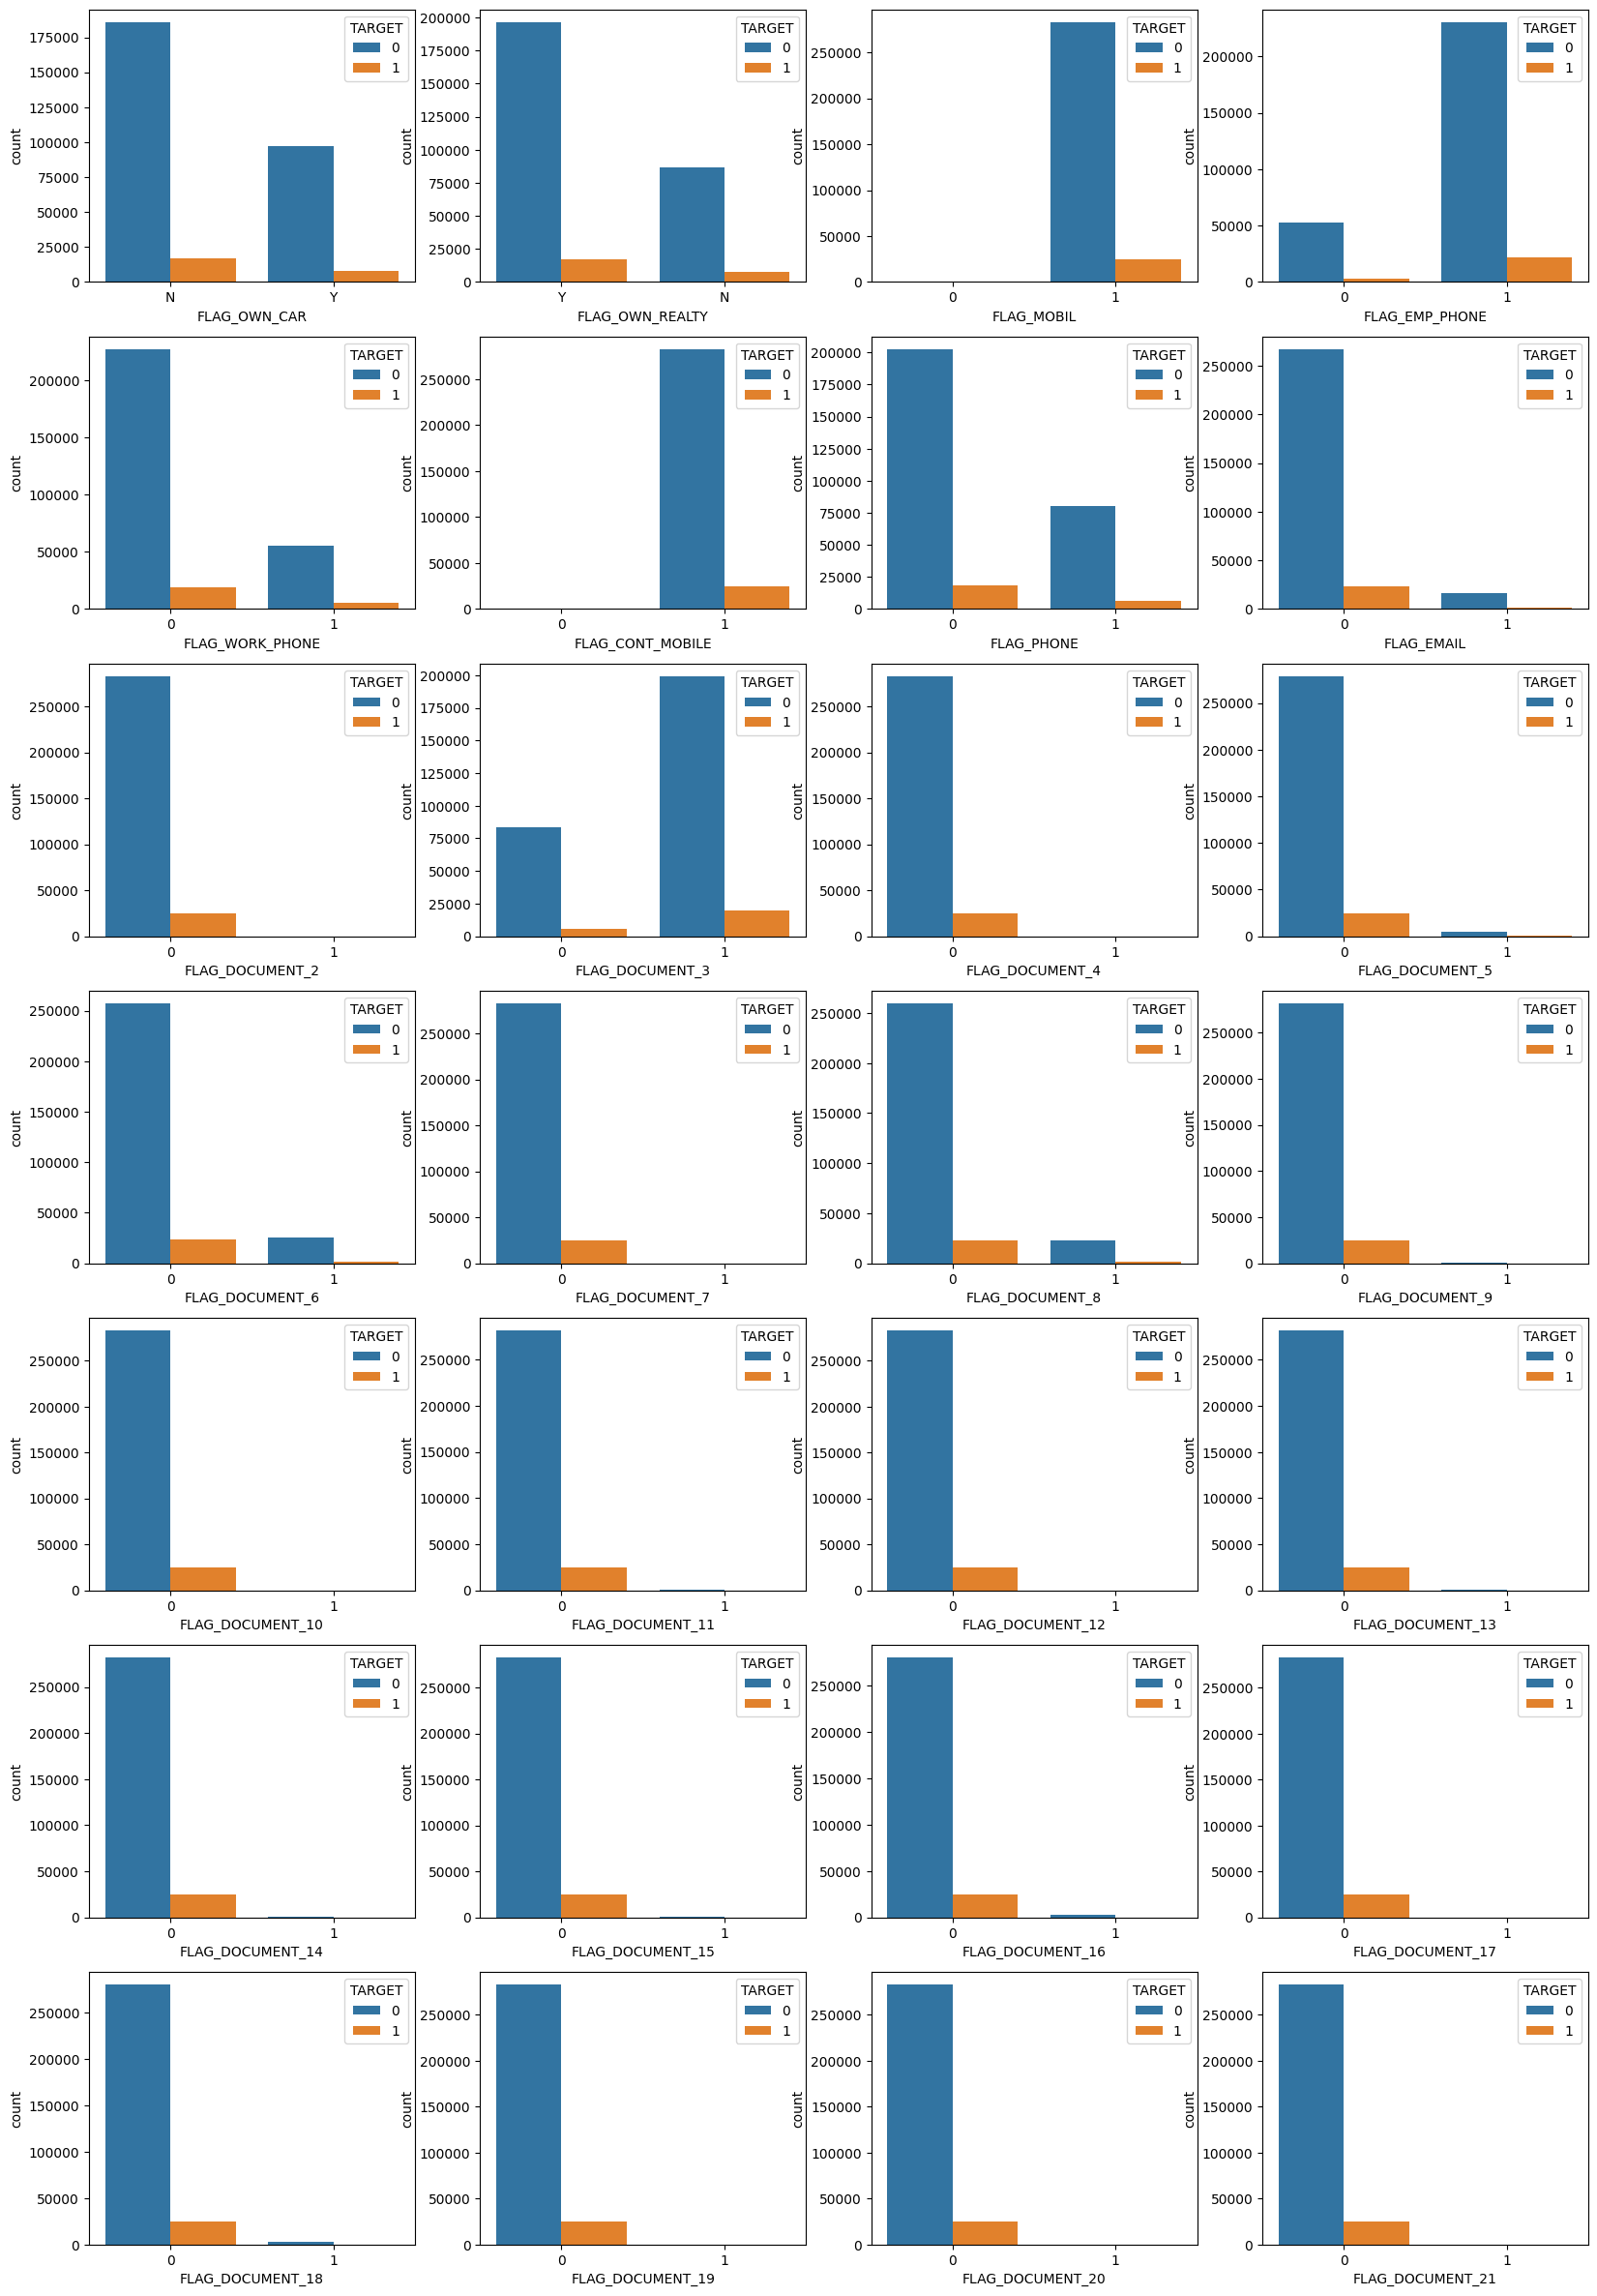

In [15]:
plt.figure(figsize= (20,30))

for i, col in enumerate(flag_col):
    plt.subplot(7,4,i+1)
    sns.countplot(data= flag_target, x= col, hue= "TARGET")

In [16]:
flag_list1=['FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','TARGET']
flag_corr_df= app_updated[flag_list1]


In [17]:
flag_corr_df.groupby(['FLAG_OWN_CAR']).size()

FLAG_OWN_CAR
N    202924
Y    104587
dtype: int64

In [18]:
flag_corr_df['FLAG_OWN_CAR']= flag_corr_df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
flag_corr_df['FLAG_OWN_REALTY']= flag_corr_df['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})

<ipython-input-18-6c0bbcfb8c10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flag_corr_df['FLAG_OWN_CAR']= flag_corr_df['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
<ipython-input-18-6c0bbcfb8c10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flag_corr_df['FLAG_OWN_REALTY']= flag_corr_df['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})


<Axes: >

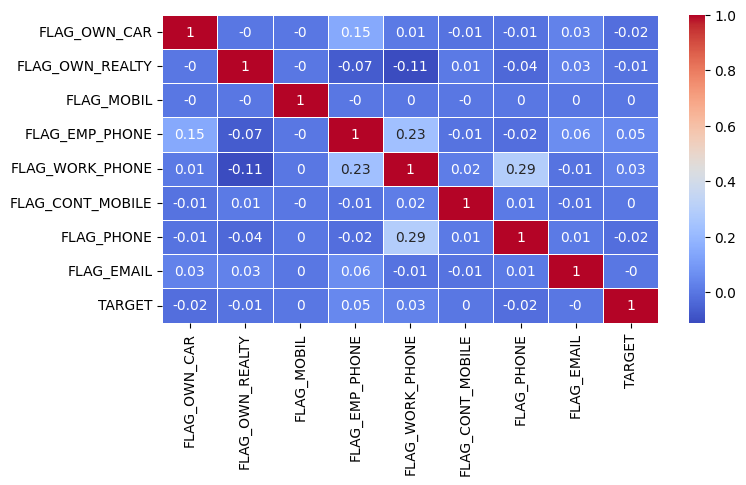

In [19]:
corr_df= round(flag_corr_df.corr(), 2)

plt.figure(figsize= (8,4))
sns.heatmap(corr_df, cmap= "coolwarm", linewidths= 0.5, annot= True)

In [20]:
app_flag_updated= app_updated.drop(labels= flag_col, axis= 1)
app_flag_updated.shape

(307511, 45)

In [21]:
app_flag_updated.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

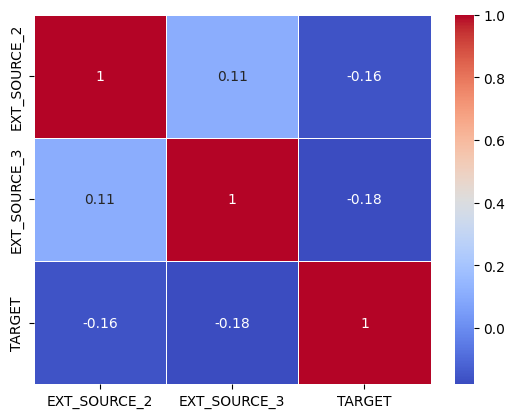

In [22]:
sns.heatmap(data= round(app_flag_updated[['EXT_SOURCE_2', 'EXT_SOURCE_3', "TARGET"]].corr(), 2), cmap= "coolwarm", linewidths= 0.5, annot= True)

In [23]:
app_new_col= app_flag_updated.drop(['EXT_SOURCE_2', 'EXT_SOURCE_3'], axis= 1)
app_new_col.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


**Feature Engineering**

In [24]:
app_new_col.isnull().sum().sort_values()

SK_ID_CURR                         0
ORGANIZATION_TYPE                  0
LIVE_CITY_NOT_WORK_CITY            0
REG_CITY_NOT_WORK_CITY             0
REG_CITY_NOT_LIVE_CITY             0
LIVE_REGION_NOT_WORK_REGION        0
REG_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_LIVE_REGION         0
HOUR_APPR_PROCESS_START            0
WEEKDAY_APPR_PROCESS_START         0
REGION_RATING_CLIENT_W_CITY        0
DAYS_ID_PUBLISH                    0
DAYS_REGISTRATION                  0
DAYS_EMPLOYED                      0
DAYS_BIRTH                         0
REGION_RATING_CLIENT               0
NAME_HOUSING_TYPE                  0
TARGET                             0
NAME_CONTRACT_TYPE                 0
REGION_POPULATION_RELATIVE         0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
CODE_GENDER                        0
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
D

Missing Imputation

In [25]:
app_new_col.groupby('CNT_FAM_MEMBERS').size()

CNT_FAM_MEMBERS
1.0      67847
2.0     158357
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
11.0         1
12.0         2
13.0         1
14.0         2
15.0         1
16.0         2
20.0         2
dtype: int64

In [26]:
fam_mem= app_new_col['CNT_FAM_MEMBERS'].mode()[0]
app_new_col['CNT_FAM_MEMBERS'].fillna(fam_mem, inplace= True)
app_new_col['CNT_FAM_MEMBERS'].isnull().sum()

0

In [27]:
app_new_col.groupby('OCCUPATION_TYPE').size()

OCCUPATION_TYPE
Accountants               9813
Cleaning staff            4653
Cooking staff             5946
Core staff               27570
Drivers                  18603
HR staff                   563
High skill tech staff    11380
IT staff                   526
Laborers                 55186
Low-skill Laborers        2093
Managers                 21371
Medicine staff            8537
Private service staff     2652
Realty agents              751
Sales staff              32102
Secretaries               1305
Security staff            6721
Waiters/barmen staff      1348
dtype: int64

In [28]:
app_new_col['OCCUPATION_TYPE'].fillna('Unknown', inplace= True)
app_new_col['OCCUPATION_TYPE'].isnull().sum()

0

In [29]:
app_new_col.groupby('NAME_TYPE_SUITE').size()

NAME_TYPE_SUITE
Children             3267
Family              40149
Group of people       271
Other_A               866
Other_B              1770
Spouse, partner     11370
Unaccompanied      248526
dtype: int64

In [30]:
suite= app_new_col['NAME_TYPE_SUITE'].mode()[0]
app_new_col['NAME_TYPE_SUITE'].fillna(suite, inplace= True)
app_new_col['NAME_TYPE_SUITE'].isnull().sum()

0

In [31]:
app_new_col['AMT_ANNUITY'].describe()

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

In [32]:
annuity= app_new_col['AMT_ANNUITY'].mean()
app_new_col['AMT_ANNUITY'].fillna(annuity, inplace= True)
app_new_col['AMT_ANNUITY'].isnull().sum()

0

In [33]:
app_new_col.groupby('OBS_60_CNT_SOCIAL_CIRCLE').size()

OBS_60_CNT_SOCIAL_CIRCLE
0.0      164666
1.0       48870
2.0       29766
3.0       20215
4.0       13946
5.0        9463
6.0        6349
7.0        4344
8.0        2886
9.0        1959
10.0       1335
11.0        837
12.0        620
13.0        401
14.0        238
15.0        166
16.0        137
17.0         73
18.0         49
19.0         44
20.0         30
21.0         28
22.0         20
23.0         13
24.0         12
25.0         11
26.0          1
27.0          5
28.0          1
29.0          2
30.0          1
47.0          1
344.0         1
dtype: int64

In [34]:
app_new_col['DEF_30_CNT_SOCIAL_CIRCLE'].fillna((app_new_col['DEF_30_CNT_SOCIAL_CIRCLE'].mode()[0]), inplace= True)
app_new_col['DEF_30_CNT_SOCIAL_CIRCLE'].isnull().sum()

0

In [35]:
app_new_col['DEF_60_CNT_SOCIAL_CIRCLE'].fillna((app_new_col['DEF_60_CNT_SOCIAL_CIRCLE'].mode()[0]), inplace= True)
app_new_col['DEF_60_CNT_SOCIAL_CIRCLE'].isnull().sum()

0

In [36]:
app_new_col['OBS_30_CNT_SOCIAL_CIRCLE'].fillna((app_new_col['OBS_30_CNT_SOCIAL_CIRCLE'].mode()[0]), inplace= True)
app_new_col['OBS_30_CNT_SOCIAL_CIRCLE'].isnull().sum()

0

In [37]:
app_new_col['OBS_60_CNT_SOCIAL_CIRCLE'].fillna((app_new_col['OBS_60_CNT_SOCIAL_CIRCLE'].mode()[0]), inplace= True)
app_new_col['OBS_60_CNT_SOCIAL_CIRCLE'].isnull().sum()

0

In [38]:
app_new_col.groupby('AMT_REQ_CREDIT_BUREAU_MON').size()

AMT_REQ_CREDIT_BUREAU_MON
0.0     222233
1.0      33147
2.0       5386
3.0       1991
4.0       1076
5.0        602
6.0        343
7.0        298
8.0        185
9.0        206
10.0       132
11.0       119
12.0        77
13.0        72
14.0        40
15.0        35
16.0        23
17.0        14
18.0         6
19.0         3
22.0         1
23.0         1
24.0         1
27.0         1
dtype: int64

In [39]:
amt_req= []
for col in app_new_col.columns:
    if col.startswith('AMT_REQ_CREDIT_BUREAU_'):
        amt_req.append(col)

amt_req


['AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [40]:
for col in amt_req:
    app_new_col[col].fillna((app_new_col[col].mode()[0]), inplace= True)

In [41]:
app_new_col['AMT_REQ_CREDIT_BUREAU_MON'].isnull().sum()

0

In [42]:
round(app_new_col['AMT_GOODS_PRICE'].describe(), 2)

count     307233.00
mean      538396.21
std       369446.46
min        40500.00
25%       238500.00
50%       450000.00
75%       679500.00
max      4050000.00
Name: AMT_GOODS_PRICE, dtype: float64

In [43]:
amt_goods= app_new_col['AMT_GOODS_PRICE'].mode()[0]
app_new_col['AMT_GOODS_PRICE'].fillna(amt_goods, inplace= True)
app_new_col['AMT_GOODS_PRICE'].isnull().sum()

0

In [44]:
app_new_col.isnull().sum().sort_values()

SK_ID_CURR                     0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION     0
REG_REGION_NOT_WORK_REGION     0
LIVE_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY         0
REG_CITY_NOT_WORK_CITY         0
LIVE_CITY_NOT_WORK_CITY        0
ORGANIZATION_TYPE              0
OBS_30_CNT_SOCIAL_CIRCLE       0
DEF_30_CNT_SOCIAL_CIRCLE       0
OBS_60_CNT_SOCIAL_CIRCLE       0
DEF_60_CNT_SOCIAL_CIRCLE       0
AMT_REQ_CREDIT_BUREAU_HOUR     0
AMT_REQ_CREDIT_BUREAU_DAY      0
AMT_REQ_CREDIT_BUREAU_WEEK     0
AMT_REQ_CREDIT_BUREAU_MON      0
REGION_RATING_CLIENT_W_CITY    0
AMT_REQ_CREDIT_BUREAU_QRT      0
REGION_RATING_CLIENT           0
OCCUPATION_TYPE                0
TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
CNT_FAM_ME

In [45]:
app_new_col['DAYS_LAST_PHONE_CHANGE'].fillna(0, inplace= True)

Value Modification

In [46]:
app_new_col.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,2.0,0.0,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
day_list= []
for col in app_new_col:
    if col.startswith("DAYS"):
        day_list.append(col)

for x in day_list:
    app_new_col[x]= abs(app_new_col[x])

app_new_col.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,9461,637,3648.0,2120,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,2.0,2.0,2.0,2.0,1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,16765,1188,1186.0,291,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,1.0,0.0,1.0,0.0,828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,19046,225,4260.0,2531,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.0,0.0,0.0,0.0,815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,19005,3039,9833.0,2437,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,2.0,0.0,2.0,0.0,617.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,19932,3038,4311.0,3458,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0.0,0.0,0.0,0.0,1106.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
app_new_col.nunique().sort_values()

LIVE_REGION_NOT_WORK_REGION         2
TARGET                              2
NAME_CONTRACT_TYPE                  2
REG_REGION_NOT_LIVE_REGION          2
REG_CITY_NOT_LIVE_CITY              2
REG_CITY_NOT_WORK_CITY              2
LIVE_CITY_NOT_WORK_CITY             2
REG_REGION_NOT_WORK_REGION          2
REGION_RATING_CLIENT_W_CITY         3
REGION_RATING_CLIENT                3
CODE_GENDER                         3
NAME_EDUCATION_TYPE                 5
AMT_REQ_CREDIT_BUREAU_HOUR          5
NAME_HOUSING_TYPE                   6
NAME_FAMILY_STATUS                  6
WEEKDAY_APPR_PROCESS_START          7
NAME_TYPE_SUITE                     7
NAME_INCOME_TYPE                    8
AMT_REQ_CREDIT_BUREAU_DAY           9
DEF_60_CNT_SOCIAL_CIRCLE            9
AMT_REQ_CREDIT_BUREAU_WEEK          9
DEF_30_CNT_SOCIAL_CIRCLE           10
AMT_REQ_CREDIT_BUREAU_QRT          11
CNT_CHILDREN                       15
CNT_FAM_MEMBERS                    17
OCCUPATION_TYPE                    19
HOUR_APPR_PR

Outlier detection and treatment

Binning

In [49]:
app_new_col['AMT_GOODS_PRICE'].agg(['median', 'min', 'max'])

median     450000.0
min         40500.0
max       4050000.0
Name: AMT_GOODS_PRICE, dtype: float64

In [50]:
app_new_col['AMT_GOODS_PRICE'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

0.10     180000.0
0.20     225000.0
0.30     270000.0
0.40     378000.0
0.50     450000.0
0.60     522000.0
0.70     675000.0
0.80     814500.0
0.90    1093500.0
0.99    1800000.0
Name: AMT_GOODS_PRICE, dtype: float64

<Axes: xlabel='AMT_GOODS_PRICE', ylabel='Density'>

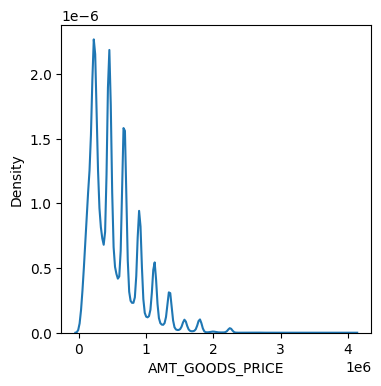

In [51]:
plt.figure(figsize= (4,4))
sns.kdeplot(data= app_new_col, x= 'AMT_GOODS_PRICE')

In [52]:
bins=[0,100000,200000,500000,1000000,2000000,4000000,5000000]
ranges= ['0-1l', '1l-2l', '2l-5l','5l-10l','10l-20l','20l-40l','40l+']
app_new_col['AMT_GOODS_PRICE_RANGE']= pd.cut(app_new_col['AMT_GOODS_PRICE'], bins, labels= ranges)

app_new_col.groupby('AMT_GOODS_PRICE_RANGE').size()

AMT_GOODS_PRICE_RANGE
0-1l         8709
1l-2l       32956
2l-5l      141231
5l-10l      90496
10l-20l     33026
20l-40l      1085
40l+            8
dtype: int64

In [53]:
app_new_col['AMT_INCOME_TOTAL'].agg(["min", "median", "max"])

min           25650.0
median       147150.0
max       117000000.0
Name: AMT_INCOME_TOTAL, dtype: float64

In [54]:
app_new_col['AMT_INCOME_TOTAL'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

0.10     81000.0
0.20     99000.0
0.30    112500.0
0.40    135000.0
0.50    147150.0
0.60    162000.0
0.70    180000.0
0.80    225000.0
0.90    270000.0
0.99    472500.0
Name: AMT_INCOME_TOTAL, dtype: float64

In [55]:
bins=[0,50000,100000,150000,200000,300000,400000,500000,1000000,10000000,117000001]
ranges= ['0-50k', '50k-1l', '1l-1.5l','1.5l-2l','2l-3l','3l-4l','4l-5l','5l-10l','1l-1cr','1cr+']
app_new_col['AMT_INCOME_TOTAL_RANGE']= pd.cut(app_new_col['AMT_INCOME_TOTAL'], bins, labels= ranges)

app_new_col.groupby('AMT_INCOME_TOTAL_RANGE').size()

AMT_INCOME_TOTAL_RANGE
0-50k       4517
50k-1l     59181
1l-1.5l    91591
1.5l-2l    64307
2l-3l      65176
3l-4l      14676
4l-5l       5361
5l-10l      2452
1l-1cr       247
1cr+           3
dtype: int64

In [56]:
app_new_col['AMT_CREDIT'].agg(["min", "median", "max"])

min         45000.0
median     513531.0
max       4050000.0
Name: AMT_CREDIT, dtype: float64

In [57]:
app_new_col['AMT_CREDIT'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

0.10     180000.0
0.20     254700.0
0.30     306306.0
0.40     432000.0
0.50     513531.0
0.60     604152.0
0.70     755190.0
0.80     900000.0
0.90    1133748.0
0.99    1854000.0
Name: AMT_CREDIT, dtype: float64

In [58]:
bins=[0,100000,200000,500000,1000000,2000000,4000000,5000000]
ranges= ['0-1l', '1l-2l', '2l-5l','5l-10l','10l-20l','20l-40l','40l+']
app_new_col['AMT_CREDIT_RANGE']= pd.cut(app_new_col['AMT_CREDIT'], bins, labels= ranges)

app_new_col.groupby('AMT_CREDIT_RANGE').size()

AMT_CREDIT_RANGE
0-1l         6004
1l-2l       30140
2l-5l      113189
5l-10l     108193
10l-20l     47956
20l-40l      2019
40l+           10
dtype: int64

In [59]:
app_new_col['DAYS_EMPLOYED'].agg(["min", "median", "max"])

min            0.0
median      2219.0
max       365243.0
Name: DAYS_EMPLOYED, dtype: float64

In [60]:
app_new_col['DAYS_EMPLOYED'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

0.10       392.0
0.20       749.0
0.30      1132.0
0.40      1597.0
0.50      2219.0
0.60      3032.0
0.70      4435.0
0.80      9188.0
0.90    365243.0
0.99    365243.0
Name: DAYS_EMPLOYED, dtype: float64

In [61]:
bins=[0,365,730,1825,3650,7300,10950]
ranges= ['0-1y', '1y-2y', '2y-5y','5y-10y','10y-20y','20y-30y']
app_new_col['DAYS_EMPLOYED_RANGE']= pd.cut(app_new_col['DAYS_EMPLOYED'], bins, labels= ranges)

app_new_col.groupby('DAYS_EMPLOYED_RANGE').size()

DAYS_EMPLOYED_RANGE
0-1y       27980
1y-2y      31845
2y-5y      76484
5y-10y     64872
10y-20y    38398
20y-30y     9551
dtype: int64

In [62]:
app_new_col['AMT_ANNUITY'].agg(["min", "median", "max"])

min         1615.5
median     24903.0
max       258025.5
Name: AMT_ANNUITY, dtype: float64

In [63]:
app_new_col['AMT_ANNUITY'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

0.10    11074.5
0.20    14701.5
0.30    18189.0
0.40    21870.0
0.50    24903.0
0.60    28062.0
0.70    32004.0
0.80    37516.5
0.90    45954.0
0.99    70006.5
Name: AMT_ANNUITY, dtype: float64

In [64]:
bins=[0,10000,20000,30000,40000,50000,2588026]
ranges= ['0-10k', '10k-20k', '20k-30k','30k-40k','40k-50k','50k+']
app_new_col['AMT_ANNUITY_RANGE']= pd.cut(app_new_col['AMT_ANNUITY'], bins, labels= ranges)

app_new_col.groupby('AMT_ANNUITY_RANGE').size()

AMT_ANNUITY_RANGE
0-10k      23283
10k-20k    83222
20k-30k    92478
30k-40k    58562
40k-50k    28669
50k+       21297
dtype: int64

In [65]:
app_new_col['DAYS_BIRTH'].agg(["min", "median", "max"])

min        7489.0
median    15750.0
max       25229.0
Name: DAYS_BIRTH, dtype: float64

In [66]:
app_new_col['DAYS_BIRTH'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])

0.10    10284.0
0.20    11694.0
0.30    13140.0
0.40    14416.0
0.50    15750.0
0.60    17220.0
0.70    18885.0
0.80    20474.0
0.90    22181.0
0.99    24419.0
Name: DAYS_BIRTH, dtype: float64

In [67]:
bins=[6570,8395,10950,14600,18250,21900,50000]
ranges= ['18y-25y', '25y-30y', '30y-40y','40y-50y','50y-60y','60y+']
app_new_col['DAYS_BIRTH_RANGE']= pd.cut(app_new_col['DAYS_BIRTH'], bins, labels= ranges)

app_new_col.groupby('DAYS_BIRTH_RANGE').size()

DAYS_BIRTH_RANGE
18y-25y     4195
25y-30y    40826
30y-40y    82308
40y-50y    76541
50y-60y    68062
60y+       35579
dtype: int64

**Data Analysis**

In [68]:
 app_new_col.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   307511 non-null  int64   
 1   TARGET                       307511 non-null  int64   
 2   NAME_CONTRACT_TYPE           307511 non-null  object  
 3   CODE_GENDER                  307511 non-null  object  
 4   CNT_CHILDREN                 307511 non-null  int64   
 5   AMT_INCOME_TOTAL             307511 non-null  float64 
 6   AMT_CREDIT                   307511 non-null  float64 
 7   AMT_ANNUITY                  307511 non-null  float64 
 8   AMT_GOODS_PRICE              307511 non-null  float64 
 9   NAME_TYPE_SUITE              307511 non-null  object  
 10  NAME_INCOME_TYPE             307511 non-null  object  
 11  NAME_EDUCATION_TYPE          307511 non-null  object  
 12  NAME_FAMILY_STATUS           307511 non-null

In [69]:
app_new_col.dtypes.value_counts()

float64     18
int64       15
object      10
category     2
category     1
category     1
category     1
category     1
Name: count, dtype: int64

Univariate analysis (object variables)

In [70]:
app_new_col.select_dtypes(include= ['object']).head()

,NAME_CONTRACT_TYPE,CODE_GENDER,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [71]:
app_new_col.groupby(['NAME_CONTRACT_TYPE']).size()

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
dtype: int64

<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='count'>

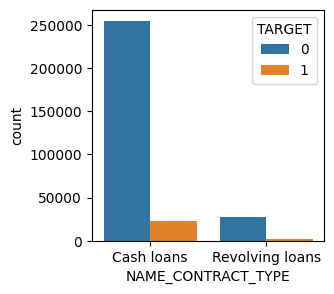

In [72]:
plt.figure(figsize= (3,3))
sns.countplot(data= app_new_col, x= 'NAME_CONTRACT_TYPE', hue='TARGET')

In [73]:
data_pct= app_new_col[['NAME_CONTRACT_TYPE', 'TARGET']].groupby('NAME_CONTRACT_TYPE', as_index= False).mean()
data_pct['PCT']= data_pct['TARGET']*100
data_pct

,NAME_CONTRACT_TYPE,TARGET,PCT
0,Cash loans,0.083459,8.345913
1,Revolving loans,0.054783,5.478329


<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='PCT'>

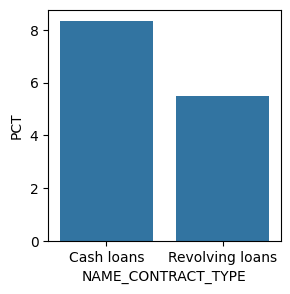

In [74]:
plt.figure(figsize= (3,3))
sns.barplot(data= data_pct, x= 'NAME_CONTRACT_TYPE', y= 'PCT')

<Axes: xlabel='NAME_CONTRACT_TYPE', ylabel='PCT'>

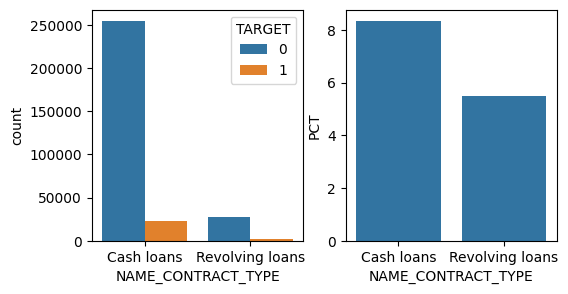

In [75]:
plt.figure(figsize= (6,3))

plt.subplot(1,2,1)
sns.countplot(data= app_new_col, x= 'NAME_CONTRACT_TYPE', hue='TARGET')

plt.subplot(1,2,2)
sns.barplot(data= data_pct, x= 'NAME_CONTRACT_TYPE', y= 'PCT')

In [76]:
app_new_col.groupby(['CODE_GENDER']).size()

CODE_GENDER
F      202448
M      105059
XNA         4
dtype: int64

In [77]:
data_pct= app_new_col[['CODE_GENDER', 'TARGET']].groupby('CODE_GENDER', as_index= False).mean()
data_pct['PCT']= data_pct['TARGET']*100
data_pct

,CODE_GENDER,TARGET,PCT
0,F,0.069993,6.999328
1,M,0.101419,10.141920
2,XNA,0.000000,0.000000


<Axes: xlabel='CODE_GENDER', ylabel='PCT'>

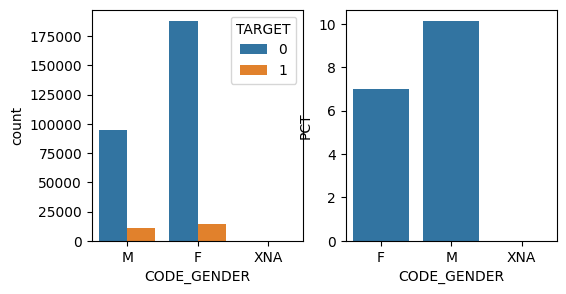

In [78]:
plt.figure(figsize= (6,3))

plt.subplot(1,2,1)
sns.countplot(data= app_new_col, x= 'CODE_GENDER', hue='TARGET')

plt.subplot(1,2,2)
sns.barplot(data= data_pct, x= 'CODE_GENDER', y= 'PCT')

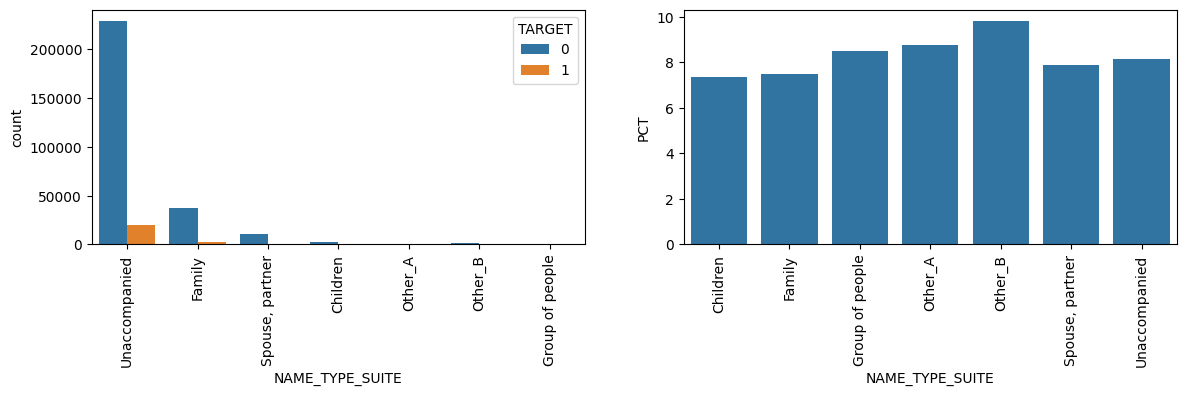

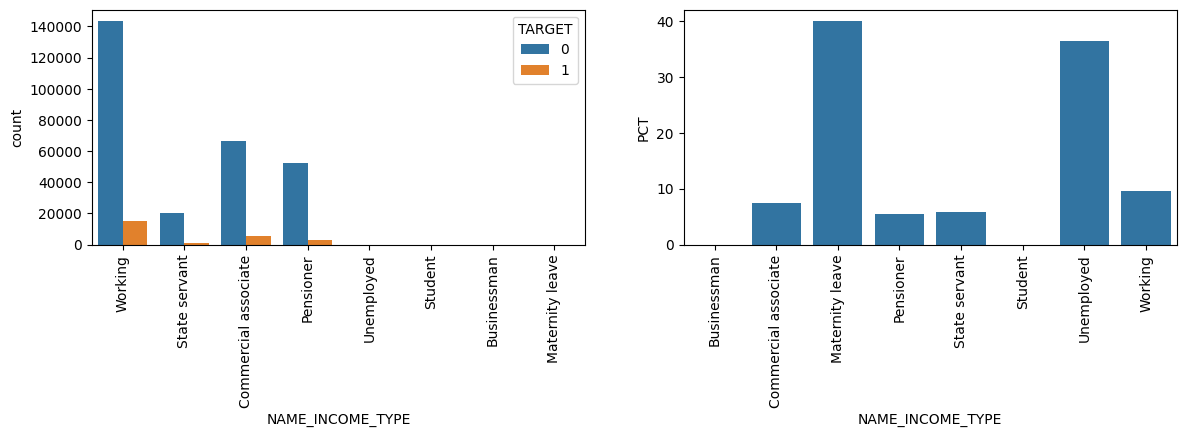

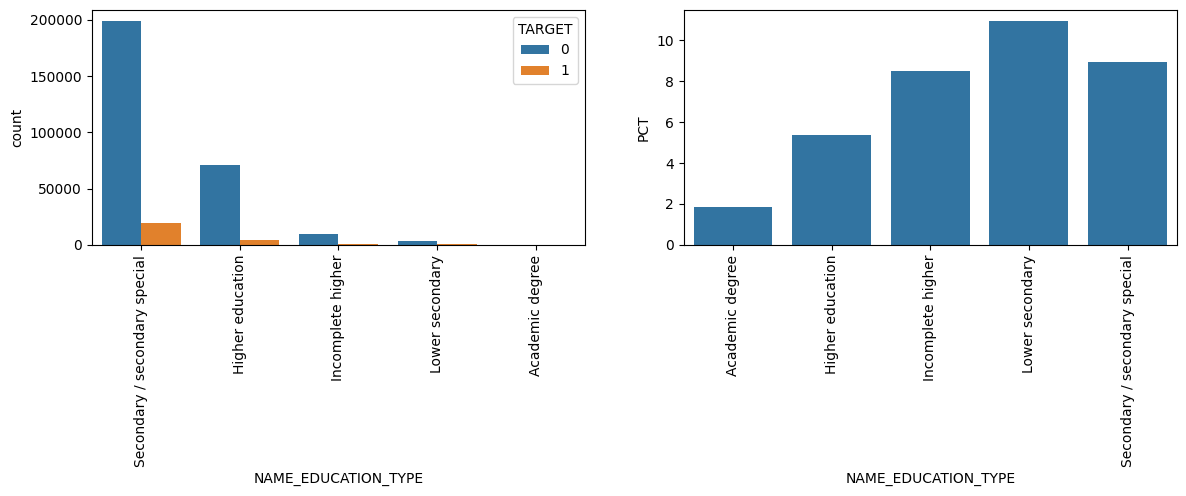

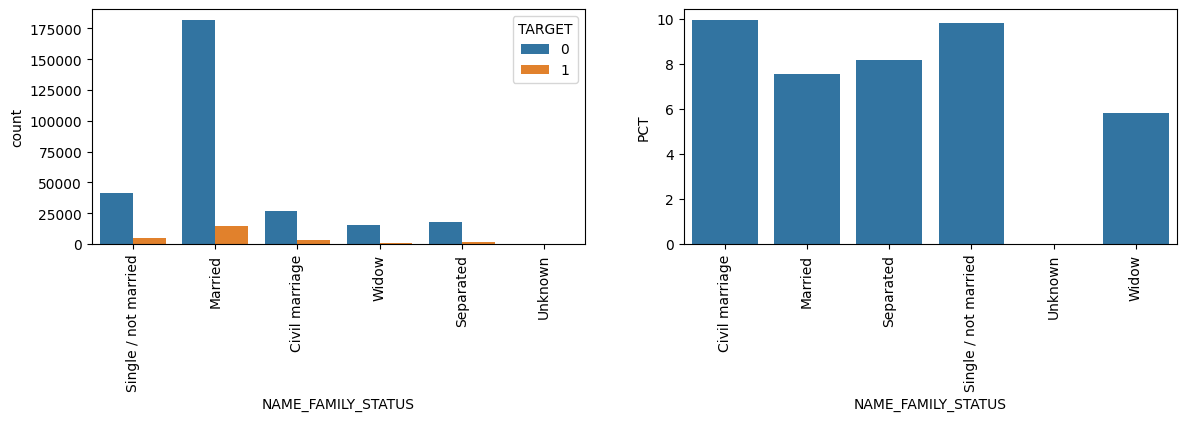

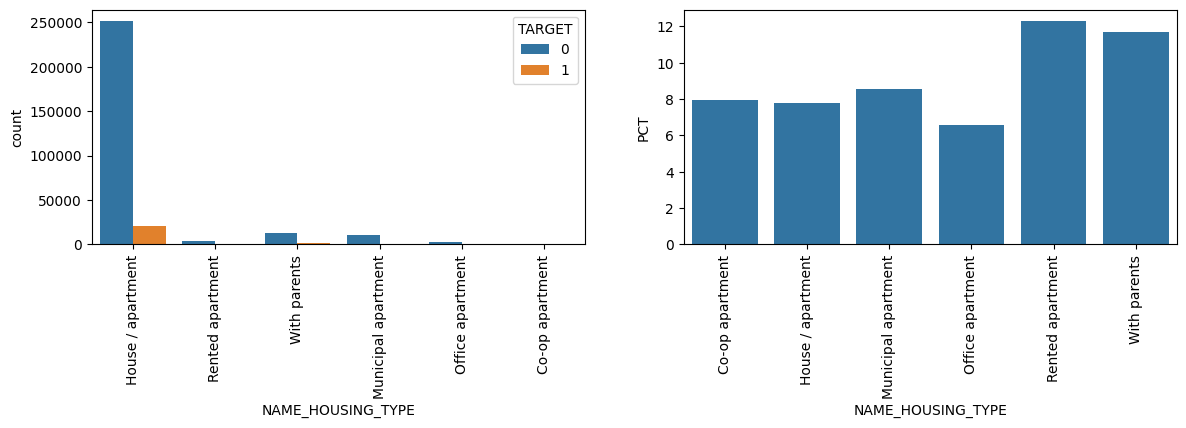

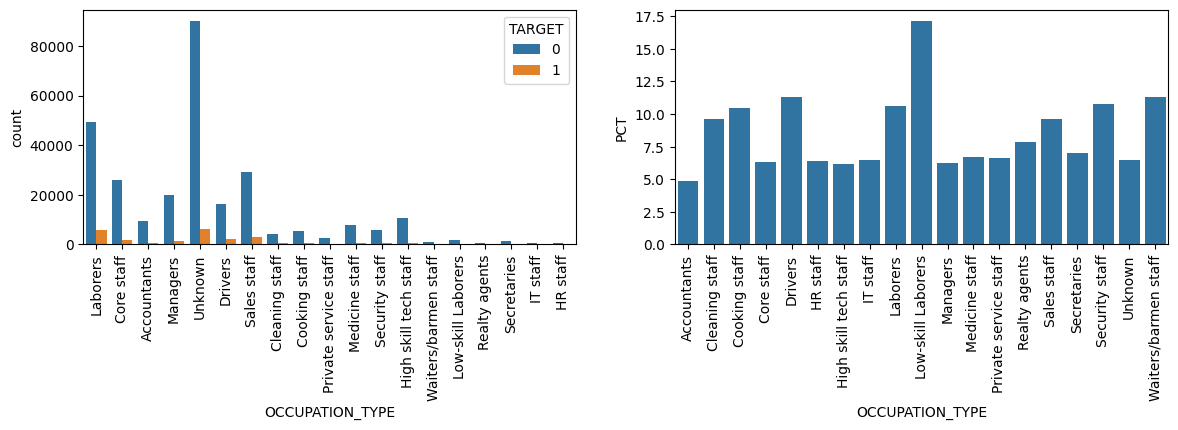

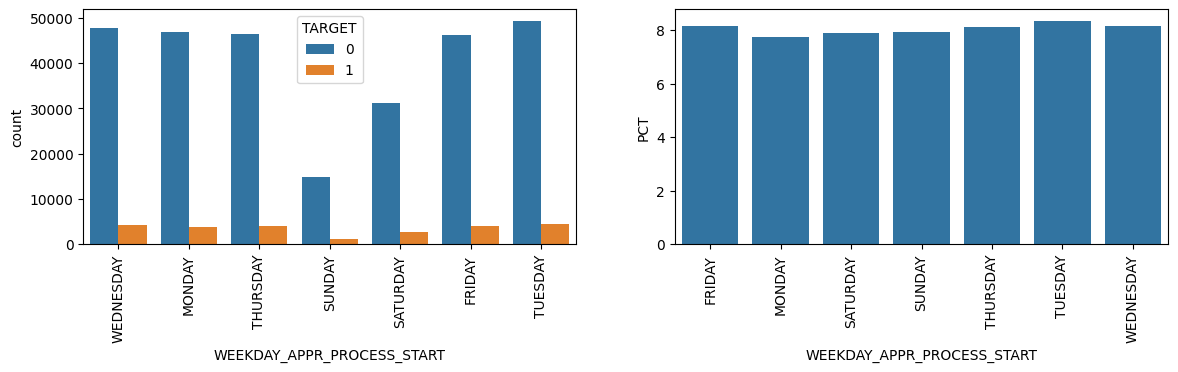

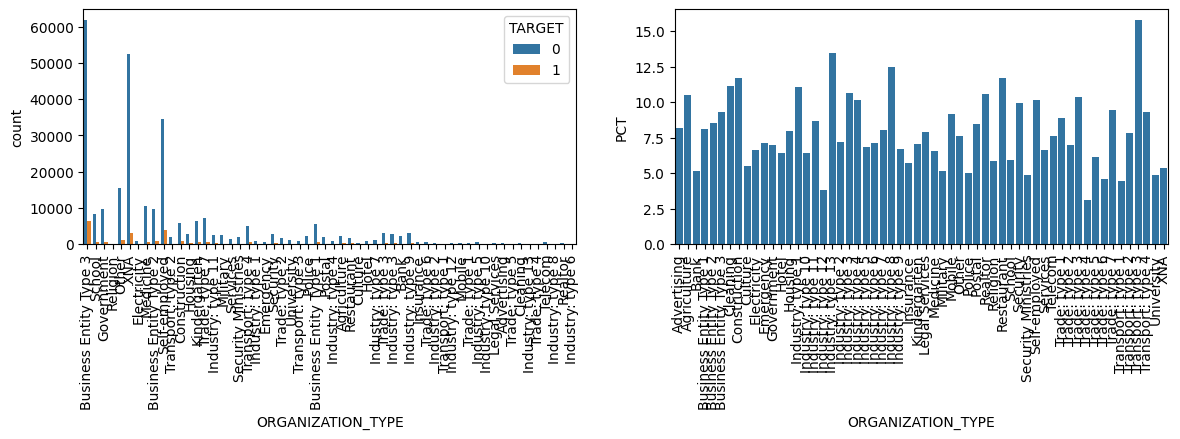

In [79]:
obj_var= app_new_col.select_dtypes(include= ['object']).columns

for i, var in enumerate(obj_var[2:]):
    plt.figure(figsize= (14,36))

    plt.subplot(10,2,i+i+1)
    sns.countplot(data= app_new_col, x= var, hue='TARGET')
    plt.xticks(rotation= 90)

    data_pct= app_new_col[[var, 'TARGET']].groupby(var, as_index= False).mean()
    data_pct['PCT']= data_pct['TARGET']*100

    plt.subplot(10,2,i+i+2)
    sns.barplot(data= data_pct, x= var, y= 'PCT')
    plt.xticks(rotation= 90)

In [80]:
for var in obj_var:
    print(app_new_col.groupby([var]).size())

NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
dtype: int64
CODE_GENDER
F      202448
M      105059
XNA         4
dtype: int64
NAME_TYPE_SUITE
Children             3267
Family              40149
Group of people       271
Other_A               866
Other_B              1770
Spouse, partner     11370
Unaccompanied      249818
dtype: int64
NAME_INCOME_TYPE
Businessman                 10
Commercial associate     71617
Maternity leave              5
Pensioner                55362
State servant            21703
Student                     18
Unemployed                  22
Working                 158774
dtype: int64
NAME_EDUCATION_TYPE
Academic degree                     164
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Secondary / secondary special    218391
dtype: int64
NAME_FAMILY_STATUS
Civil marriage           29775
Married                 196432
Separated                19770
Single / not ma

Numerical Variables

In [81]:
app_new_col.dtypes.value_counts()

float64     18
int64       15
object      10
category     2
category     1
category     1
category     1
category     1
Name: count, dtype: int64

In [82]:
num_var= app_new_col.select_dtypes(include= ['float64', 'int64']).columns
num_cat_var= app_new_col.select_dtypes(include= ['float64', 'int64', 'category']).columns
num_var

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [83]:
app_new_col.groupby('TARGET').size()/app_new_col.shape[0]*100

TARGET
0    91.927118
1     8.072882
dtype: float64

In [84]:
num_data= app_new_col[num_var]
defaulters= num_data[num_data['TARGET']== 1].drop(['TARGET'], axis= 1)
non_def= num_data[num_data['TARGET']== 0].drop(['TARGET'], axis= 1)

In [85]:
def_corr= defaulters.corr()
def_corr_new= def_corr.where(np.triu(np.ones(def_corr.shape), k= 1).astype('bool')).unstack().reset_index().rename(columns= {'level_0': 'var1',
                                                                                                                             'level_1': 'var2',
                                                                                                                             0: 'corr'})
def_corr_new['corr']= abs(def_corr_new['corr'])
def_corr_new.dropna(subset= ['corr']).sort_values(by = ['corr'], ascending= False).head(10)

,var1,var2,corr
757,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998270
163,AMT_GOODS_PRICE,AMT_CREDIT,0.982783
428,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,0.956637
353,CNT_FAM_MEMBERS,CNT_CHILDREN,0.885484
790,DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,0.869016
560,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,0.847885
659,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,0.778540
164,AMT_GOODS_PRICE,AMT_ANNUITY,0.752295
131,AMT_ANNUITY,AMT_CREDIT,0.752195
263,DAYS_EMPLOYED,DAYS_BIRTH,0.582185


In [86]:
non_def_corr= non_def.corr()
non_def_corr_new= non_def_corr.where(np.triu(np.ones(non_def_corr.shape), k= 1).astype('bool')).unstack().reset_index().rename(columns= {'level_0': 'var1',
                                                                                                                             'level_1': 'var2',
                                                                                                                             0: 'corr'})
non_def_corr_new['corr']= abs(non_def_corr_new['corr'])
non_def_corr_new.dropna(subset= ['corr']).sort_values(by = ['corr'], ascending= False).head(10)

,var1,var2,corr
757,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998510
163,AMT_GOODS_PRICE,AMT_CREDIT,0.987022
428,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,0.950149
353,CNT_FAM_MEMBERS,CNT_CHILDREN,0.878571
560,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,0.861861
790,DEF_60_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,0.859371
659,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,0.830381
164,AMT_GOODS_PRICE,AMT_ANNUITY,0.776421
131,AMT_ANNUITY,AMT_CREDIT,0.771297
263,DAYS_EMPLOYED,DAYS_BIRTH,0.626114


Univariate analysis on numerical values

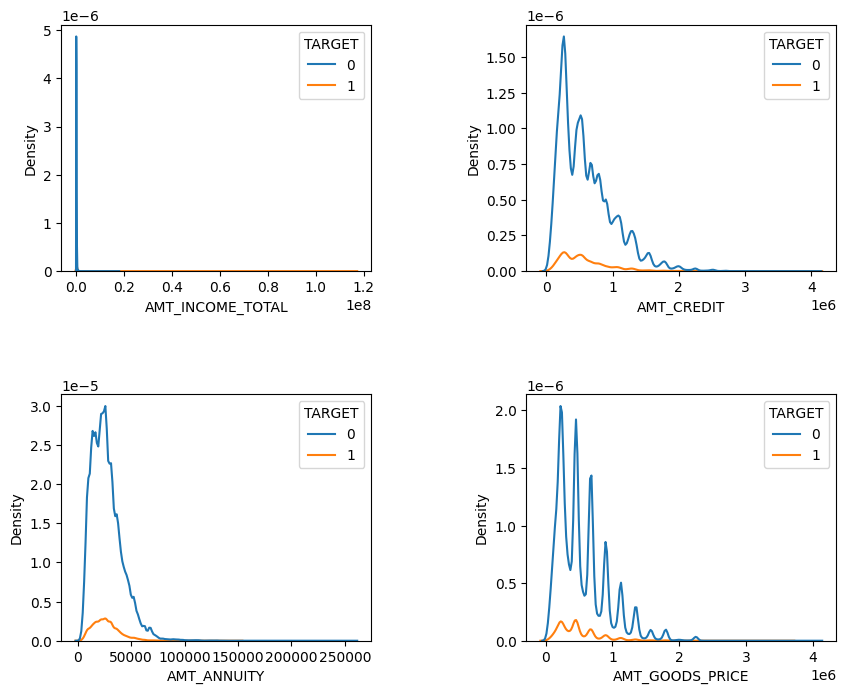

In [87]:
amt_var= ['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
plt.figure(figsize= (10,8))
for i, var in enumerate(amt_var):
    plt.subplot(2,2,i+1)
    sns.kdeplot(data= num_data, x= var, hue= 'TARGET' )
    plt.subplots_adjust(wspace= 0.5, hspace= 0.5)


Bivariate analysis on numeric variables

<Axes: xlabel='AMT_CREDIT', ylabel='AMT_GOODS_PRICE'>

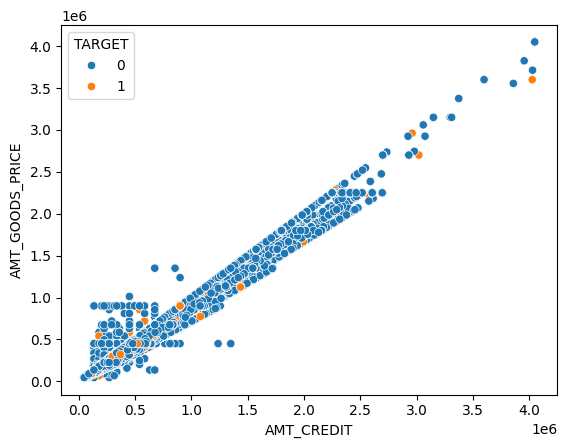

In [88]:
sns.scatterplot(data= num_data, x= 'AMT_CREDIT', y= 'AMT_GOODS_PRICE', hue= 'TARGET')

<Axes: xlabel='AMT_CREDIT', ylabel='AMT_INCOME_TOTAL'>

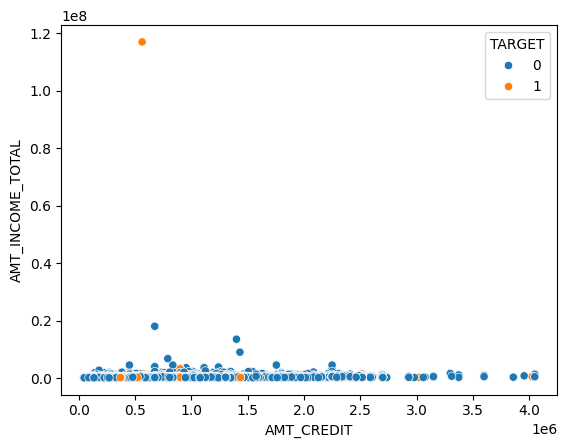

In [89]:
sns.scatterplot(data= num_data, x= 'AMT_CREDIT', y= 'AMT_INCOME_TOTAL', hue= 'TARGET')

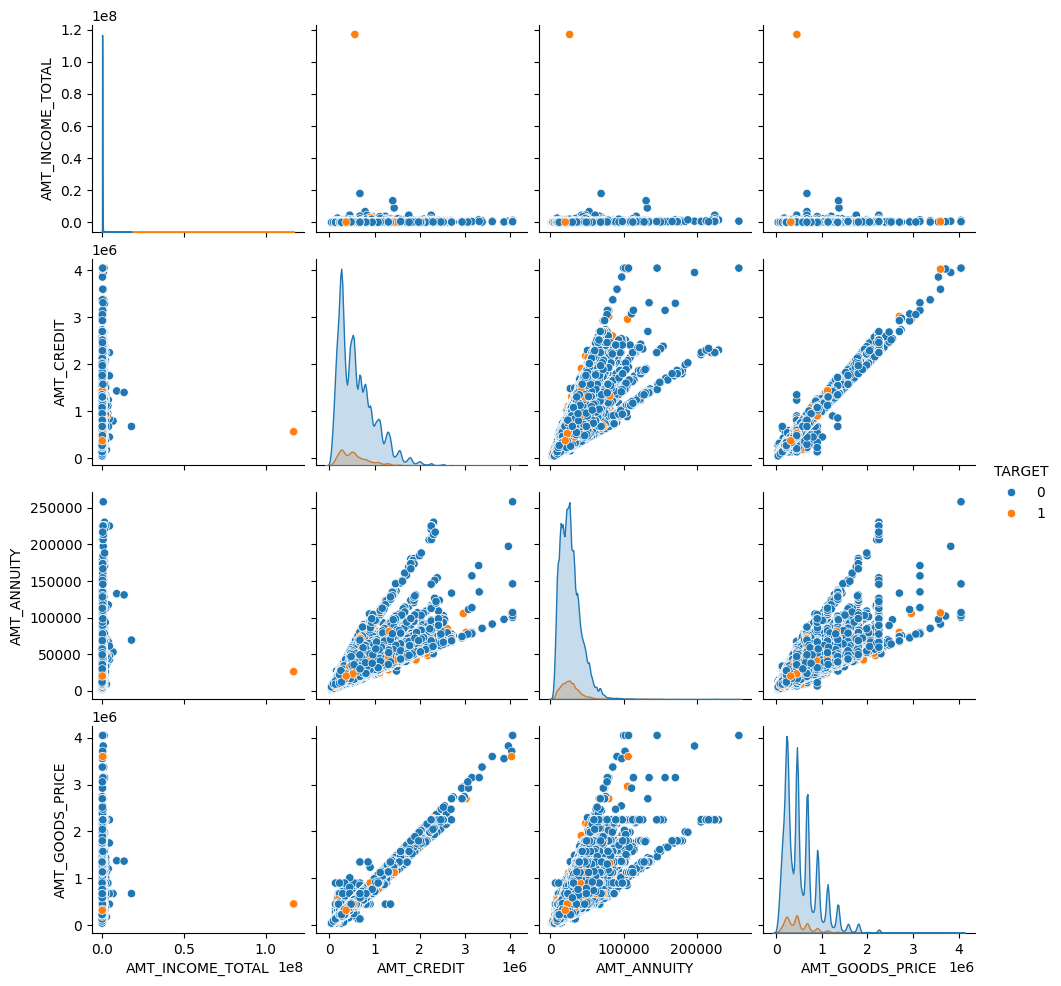

In [90]:
amt_var= num_data[['AMT_INCOME_TOTAL','AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'TARGET']]
sns.pairplot(data= amt_var, hue= 'TARGET')

**Analyzing previous data**

In [91]:
prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
null_count= pd.DataFrame(prev_app.isnull().sum().sort_values().reset_index())
null_count.rename(columns={'index':'col_name', 0:'null_count'}, inplace= True)
null_count["null_percent"]= (null_count["null_count"]/prev_app.shape[0])*100
null_count

,col_name,null_count,null_percent
0,SK_ID_PREV,0,0.000000
1,NAME_YIELD_GROUP,0,0.000000
2,NAME_SELLER_INDUSTRY,0,0.000000
3,SELLERPLACE_AREA,0,0.000000
4,CHANNEL_TYPE,0,0.000000
5,NAME_PRODUCT_TYPE,0,0.000000
6,NAME_PORTFOLIO,0,0.000000
7,NAME_GOODS_CATEGORY,0,0.000000
8,NAME_CLIENT_TYPE,0,0.000000
9,CODE_REJECT_REASON,0,0.000000


In [93]:
extra_rows_prev= null_count[null_count['null_percent']>=40]
extra_rows_prev_list= extra_rows_prev['col_name'].to_list()
prev_app_updated= prev_app.drop(labels= extra_rows_prev_list, axis= 1)
prev_app_updated.shape

(1670214, 26)

In [94]:
other_var= ['HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY']
prev_updated= prev_app_updated.drop(labels= other_var, axis= 1)

In [95]:
prev_updated.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,XAP,Approved,-73,Cash through the bank,XAP,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,XNA,Approved,-164,XNA,XAP,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,XNA,Approved,-301,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,XNA,Approved,-512,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,Repairs,Refused,-781,Cash through the bank,HC,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high


**Conclusion**

In [96]:
# most of the customers have taken cash loan
# customers who have taken cash loans are less likely to default
#
# CODE_GENDER -
#
#     most of the loans have been taken by female
#     default rate for females are just ~7% which is safer and lesser than male
#
# NAME_TYPE_SUITE -
#
#     unacompanied people had tanke most of the loans and the default rate is ~8.5% which is still okay
#
# NAME_INCOME_TYPE -
#
#     the safest segments are working, commercial associates and pensioners
#
# NAME_EDUCATION_TYPE -
#
#     Higher education is the safest segment to give the loan with a default rate of less than 5%
#
# NAME_FAMILY_STATUS -
#
#     Married people are safe to target, default rate is 8%
#
#
# NAME_HOUSING_TYPE -
#
#     People having house/appartment are safe to give the loan with default rate of ~8%
#
# OCCUPATION_TYPE -
#
#     Low-Skill Laboreres and drivers are highest defaulters
#     Accountants are less defaulters
#     Core staff, Managers and Laborers are safer to target with a default rate of <= 7.5 to 10%
#
# ORGANIZATION_TYPE -
#
#     Transport type 3 highest defaulter
#     Others, Business Entity Type 3, Self Employed are good to go with default rate around 10 %
#
# =======univariate numeric variables analysis========
#
#     >> most of the loans were given for the goods price ranging between 0 to 1 ml
#     >> most of the loans were given for the credit amount of 0 to 1 ml
#     >> most of the customers are paying annuity of 0 to 50 K
#     >> mostly the customers have income between 0 to 1 ml
#
# =============bivariate analysis==================
#
#     >> AMT_CREDIT and AMT_GOODS_PRICE are linearly corelated, if the AMT_CREDIT increases the defaulters are decreasing
#     >> people having income less than or equals to 1 ml, are more like to take loans out of which who are taking loan of less than 1.5 million, coudl turn out to be defaulters. we can target income below 1 million and loan maount greater than 1.5 million
#     >> people having children 1 to less than 5 are safer to give the loan
#     >> People who can pay the annuity of 100K are more like to get the loan and that's upto less than 2ml (safer segment)
#
# ============analysis on merged data==============
#
#     >> for the repairing purpose customers had applied mostly prev. and the same puspose has most number of cancelations
#     >> most of the app. which were prev. either canceled or refused 80-90% of them are repayer in the current data
#     >> offers which were unused prev. now have maximum number of defaulters despite of having high income band customers

# # Final Conclusion/Insights

# Bank should target the customers
#
#     >> having low income i.e. below 1 ml
#     >> working in Others, Business Entity Type 3, Self Employed  org. type
#     >> working as Accountants, Core staff, Managers and Laborers
#     >> having house/appartment and are married and having children not more than 5
#     >> Highly educated
#     >> preferably female
#
#     >> unacompanied people can be safer -  default rate is ~8.5%
#
# Amount segment recommended -
#
#     >> the credit amount should not be more than 1 ml
#     >> annuity can be made of 50K (depending on the eligibility)
#     >> income bracket could be below 1 ml
#
#     >> 80-90% of the customer who were prev. canceled/refused, are repayers. Bank can do the analysis and can consider to give loan to these segments
#
#
# ====================precautions===============
#
#     >> org. Transport type 3 should be avoided
#     >> Low-Skill Laboreres and drivers  should be avoided
#     >> offers prev. unused and high income customer should be avoided
#